In [8]:
from torchvision.utils import make_grid as make_image_grid

import torch 
from torch import nn
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader
from torch.autograd import Variable

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

In [9]:
device="cpu"

In [10]:
trainloader = DataLoader(
    MNIST(root='./data',train=True,download=True,transform=transforms.ToTensor()),
    batch_size=128,shuffle=True)
testloader = DataLoader(
    MNIST(root='./data',train=False,download=True,transform=transforms.ToTensor()),
    batch_size=128,shuffle=True)

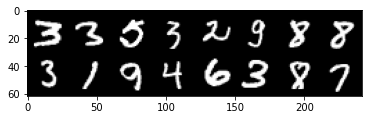

In [11]:
images,_ = iter(testloader).next()
images = images[:16]
plt.imshow(np.transpose(make_image_grid(images).numpy(), (1,2,0)))

In [12]:
class VAE(nn.Module):
    def __init__(self,input_shape, latent_dim=2,hidden_dim=500, return_zs = False):
        super(VAE,self).__init__()
        self.return_zs = return_zs
        self.input_shape = input_shape
        self.input_dim = int(input_shape[0]*input_shape[1])
        self.fc_e = nn.Sequential(nn.Linear(self.input_dim,hidden_dim),
                                  nn.ReLU(),
                                  nn.Linear(hidden_dim, hidden_dim),
                                  nn.ReLU(),
                                  nn.Linear(hidden_dim, hidden_dim),
                                  nn.ReLU(),
                                  nn.Linear(hidden_dim, hidden_dim),
                                  nn.ReLU())
        self.fc_mean = nn.Linear(hidden_dim,latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim,latent_dim)
        self.fc_d = nn.Sequential(nn.Linear(latent_dim,hidden_dim),
                                  nn.ReLU(),
                                  nn.Linear(hidden_dim, hidden_dim),
                                  nn.ReLU(),
                                  nn.Linear(hidden_dim, hidden_dim),
                                  nn.ReLU(),
                                  nn.Linear(hidden_dim, hidden_dim),
                                  nn.ReLU(),
                                  nn.Linear(hidden_dim,self.input_dim),
                                  nn.Sigmoid())
            
    def encoder(self,x_in):
        x = self.fc_e(x_in.view(-1,self.input_dim))
        mean = self.fc_mean(x)
        logvar = self.fc_logvar(x)
        return mean, logvar
    
    def decoder(self,z):
        x_out = self.fc_d(z)
        return x_out.view(-1,1,*self.input_shape)
    
    def sample_normal(self,mean,logvar):
        sd = torch.exp(logvar*0.5)
        e = torch.tensor(torch.randn(sd.size()))
        z = e.mul(sd).add_(mean)
        return z
    
    def forward(self,x_in):
        z_mean, z_logvar = self.encoder(x_in)
        z = self.sample_normal(z_mean,z_logvar)
        x_out = self.decoder(z)
        if self.return_zs:
            return x_out, z_mean, z_logvar, z
        return x_out, z_mean, z_logvar

model = VAE((28,28), latent_dim=2,hidden_dim=512)

In [13]:
def nll_gauss(mean, std, x, axis=None):
    """Gaussian log likelihood"""
    var = std**2
    const = torch.log(torch.tensor(2*np.pi))*torch.ones(x.shape)
    ll = const - 0.5*torch.log(var) - 0.5*torch.div((mean-x)**2,var)
    return -torch.sum(ll) if axis is None else -torch.sum(ll, axis=axis) 
def elbo(x, z_mu, z_logvar, out_mean, sigma=0.1,beta=1.0):
    out_std = torch.ones_like(out_mean) *sigma
    elbo_KL = beta*(-0.5*torch.sum(1+ z_logvar - (z_mu**2) - torch.exp(z_logvar)))
    elbo_nll = nll_gauss(out_mean, out_std, x)
    return (elbo_nll + elbo_KL)/x.size(0)

def visualize_mnist_vae(model,dataloader,num=32, names_prefix="robust_decoder_encoder_vae_"):
    def imshow(img, name):
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg,(1,2,0)))
        plt.axis('off')
        plt.savefig(name)
        plt.show()
        
    images,_ = iter(dataloader).next()
    images = images[0:num,:,:]
    x_in = torch.tensor(images)
    x_out,*params = model(x_in)
    x_out = x_out.data.cpu()
    imshow(make_image_grid(images), names_prefix+"test_images.svg")
    imshow(make_image_grid(x_out), names_prefix+"reconstructed_test_images.svg")
    
# Visualize test data encodings on the latent space
def visualize_encoder(model,dataloader, names_prefix="robust_decoder_encoder_vae_"):
    z_means_x, z_means_y, all_labels = [], [], []
    
    for images,labels in iter(dataloader):
        z_means,*params = model.encoder(images)
        z_means_x = np.append(z_means_x,z_means[:,0].data.cpu().numpy())
        z_means_y = np.append(z_means_y,z_means[:,1].data.cpu().numpy())
        all_labels = np.append(all_labels,labels.cpu().numpy())
        
    plt.figure(figsize=(6.5,5))
    plt.scatter(z_means_x,z_means_y,c=all_labels,cmap='inferno')
    plt.colorbar()
    plt.savefig(names_prefix+"latent_sapce.svg")
    plt.show()

def visualize_decoder(model,num=20,range_type='g', names_prefix="gauss_vae_"):
    image_grid = np.zeros([num*28,num*28])

    if range_type == 'l': # linear range
        # corresponds to output range of visualize_encoding()
        range_space = np.linspace(-8,8,num)
    elif range_type == 'g': # gaussian range
        range_space = norm.ppf(np.linspace(0.01,0.99,num))
    else:
        range_space = range_type

    for i, x in enumerate(range_space):
        for j, y in enumerate(reversed(range_space)):
            z = Variable(torch.FloatTensor([[x,y]]).to(device))
            image = model.decoder(z)
            image = image.data.cpu().numpy()
            image_grid[(j*28):((j+1)*28),(i*28):((i+1)*28)] = image

    plt.figure(figsize=(10, 10))
    plt.imshow(image_grid, cmap='gray')
    plt.axis("off")
    plt.savefig(names_prefix + "decoder.pdf")
    plt.show()

In [14]:
optimizer = torch.optim.Adam(model.parameters())
epochs = 4
elbo_list = []
for epoch in range(epochs):
    for images,_ in trainloader:
        x_in = images
        optimizer.zero_grad()
        x_out_mean, z_mu, z_logvar = model(x_in)
        loss = elbo(x_in, z_mu, z_logvar, x_out_mean)
        loss.backward() 
        optimizer.step()
        elbo_list.append(loss.detach().numpy())

C:\Users\manug\AppData\Local\Temp\ipykernel_35928\3685681301.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e = torch.tensor(torch.randn(sd.size()))


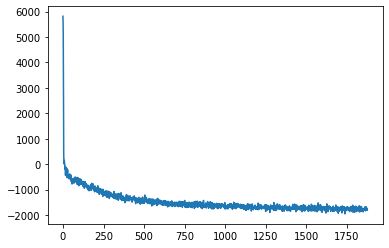

In [15]:
plt.plot(elbo_list)

C:\Users\manug\AppData\Local\Temp\ipykernel_35928\2144165698.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in = torch.tensor(images)
C:\Users\manug\AppData\Local\Temp\ipykernel_35928\3685681301.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e = torch.tensor(torch.randn(sd.size()))


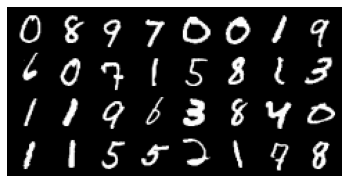

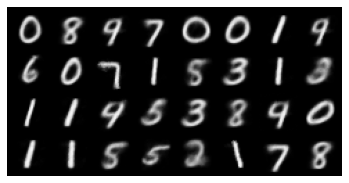

In [16]:
visualize_mnist_vae(model,trainloader)

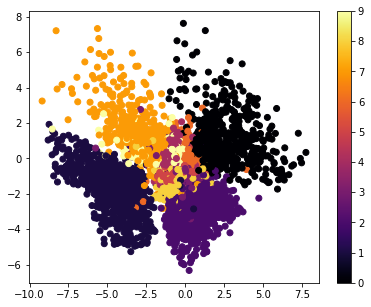

In [19]:
visualize_encoder(model,testloader)

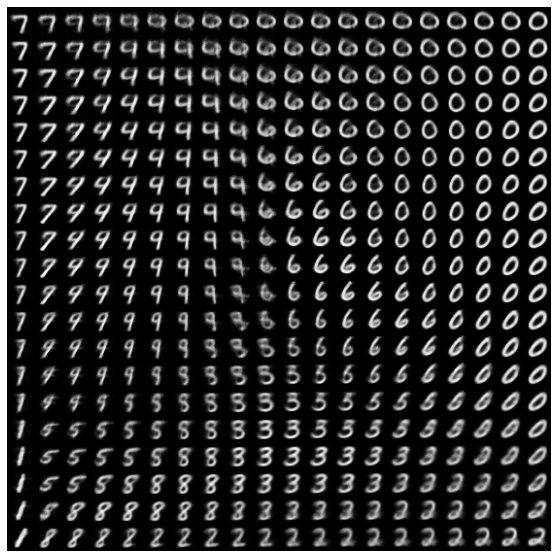

In [18]:
visualize_decoder(model)

Text(0.5, 1.0, 'Attacked point $x$                      Target $t$')

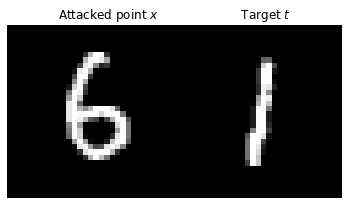

In [20]:
images,_ = iter(testloader).next()
images = images[0:2]
plt.imshow(np.transpose(make_image_grid(images).numpy(), (1,2,0)))
plt.axis("off")
plt.title(r"Attacked point $x$                      Target $t$")

In [21]:
means, logvars = model.encoder(images)
q_x = torch.distributions.MultivariateNormal(means[0], torch.eye(2)*logvars[0].exp())
q_t = torch.distributions.MultivariateNormal(means[1], torch.eye(2)*logvars[1].exp())
def distorted_latents(delta):
    means, logvars = model.encoder(images[0] + delta)
    return torch.distributions.MultivariateNormal(means, torch.eye(2)*logvars.exp())

In [22]:
delta = torch.randn(images[0].shape, requires_grad=True)

def adversarial_loss(delta, C=10):
    q_dist = distorted_latents(delta)
    loss =  torch.distributions.kl_divergence(q_dist, q_t) + C*torch.linalg.norm(delta)
    return loss

In [23]:
optimizer = torch.optim.Adam([delta], lr=5e-3)
for epoch in range(2000):
    optimizer.zero_grad()
    loss = adversarial_loss(delta, C=100)
    loss.backward(retain_graph=True) 
    if (epoch % 200) == 0:
        print(loss)
    optimizer.step()

tensor([17464.0977], grad_fn=<AddBackward0>)
tensor([2636.0088], grad_fn=<AddBackward0>)
tensor([2295.7329], grad_fn=<AddBackward0>)
tensor([1885.9220], grad_fn=<AddBackward0>)
tensor([1451.0908], grad_fn=<AddBackward0>)
tensor([1034.9977], grad_fn=<AddBackward0>)
tensor([700.2939], grad_fn=<AddBackward0>)
tensor([493.8667], grad_fn=<AddBackward0>)
tensor([414.0341], grad_fn=<AddBackward0>)
tensor([396.6293], grad_fn=<AddBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Adversarial attack')

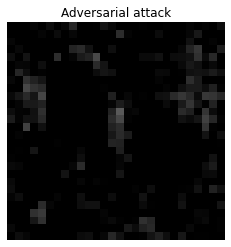

In [24]:
plt.imshow(np.transpose(make_image_grid(delta.detach()).numpy(), (1,2,0)))
plt.axis("off")
plt.title("Adversarial attack")

C:\Users\manug\AppData\Local\Temp\ipykernel_35928\3685681301.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e = torch.tensor(torch.randn(sd.size()))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Reconstructions')

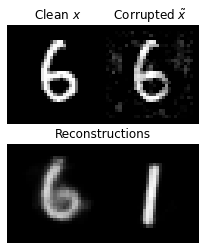

In [25]:
x_x_hat = torch.concat([images[0], images[0] + delta.detach()]).unsqueeze(1)
rec, _, _ = model(x_x_hat)

fig, axes = plt.subplots(2,1)

axes[0].imshow(np.transpose(make_image_grid(x_x_hat.detach()).numpy(), (1,2,0)))
axes[1].imshow(np.transpose(make_image_grid(rec.detach()).numpy(), (1,2,0)))

axes[0].axis("off")
axes[1].axis("off")

axes[0].set_title(r"    Clean $x$         Corrupted $\tilde{x}$")
axes[1].set_title("Reconstructions")


In [164]:
model = VAE((28,28), latent_dim=2,hidden_dim=256)

In [165]:
def batch_jacobian(func, x, create_graph=True):
  # x in shape (Batch, Length)
  def _func_sum(x):
    return func(x).sum(dim=0)
  return torch.autograd.functional.jacobian(_func_sum, x, create_graph=create_graph).permute(1,0,2)

def fisher_information(mean, var):
    return torch.diag_embed(torch.hstack([1/var, 2/var]))

def jacobian_regularizer(images):
    Js = batch_jacobian(lambda x: torch.hstack(model.encoder(x.reshape(-1, 1, 28, 28))), images.reshape(-1, 784))
    return Js@torch.transpose(Js, dim0=-2, dim1=-1)

def full_regularizer(images, z_mu, z_logvar, pert_var=1.):
    return 0.5*pert_var*torch.diagonal(fisher_information(z_mu, z_logvar.exp())@jacobian_regularizer(images), dim1=-2, dim2=-1).sum(axis=-1).mean()

In [193]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 4
elbo_list = []
for epoch in range(epochs):
    for images,_ in trainloader:
        x_in = images
        optimizer.zero_grad()
        x_out_mean, z_mu, z_logvar = model(x_in)
        loss = elbo(x_in, z_mu, z_logvar, x_out_mean) + 10*full_regularizer(x_in, z_mu, z_logvar)
        loss.backward() 
        optimizer.step()
        elbo_list.append(loss.detach().numpy())

C:\Users\manug\AppData\Local\Temp\ipykernel_35928\3685681301.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e = torch.tensor(torch.randn(sd.size()))


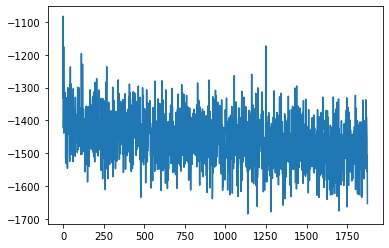

In [194]:
plt.plot(elbo_list)

C:\Users\manug\AppData\Local\Temp\ipykernel_35928\2144165698.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in = torch.tensor(images)
C:\Users\manug\AppData\Local\Temp\ipykernel_35928\3685681301.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e = torch.tensor(torch.randn(sd.size()))


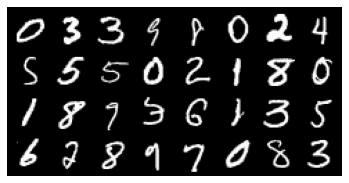

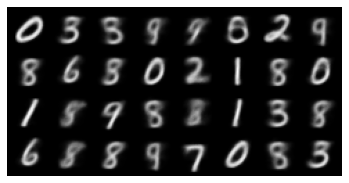

In [195]:
visualize_mnist_vae(model,trainloader)

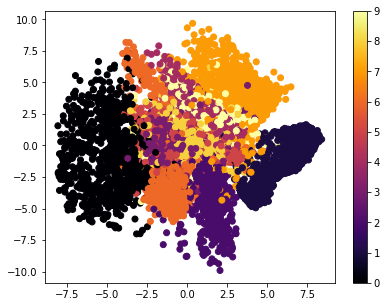

In [196]:
visualize_encoder(model,testloader)

Text(0.5, 1.0, 'Attacked point $x$                      Target $t$')

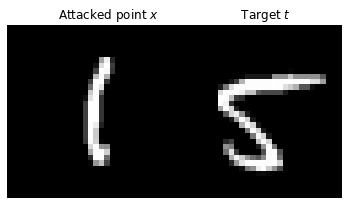

In [208]:
images,_ = iter(testloader).next()
images = images[0:2]
plt.imshow(np.transpose(make_image_grid(images).numpy(), (1,2,0)))
plt.axis("off")
plt.title(r"Attacked point $x$                      Target $t$")

In [209]:
means, logvars = model.encoder(images)
q_x = torch.distributions.MultivariateNormal(means[0], torch.eye(2)*logvars[0].exp())
q_t = torch.distributions.MultivariateNormal(means[1], torch.eye(2)*logvars[1].exp())
def distorted_latents(delta):
    means, logvars = model.encoder(images[0] + delta)
    return torch.distributions.MultivariateNormal(means, torch.eye(2)*logvars.exp())

In [210]:
delta = torch.randn(images[0].shape, requires_grad=True)

def adversarial_loss(delta, C=10):
    q_dist = distorted_latents(delta)
    loss =  torch.distributions.kl_divergence(q_dist, q_t) + C*torch.linalg.norm(delta)
    return loss

In [211]:
optimizer = torch.optim.Adam([delta], lr=5e-3)
for epoch in range(2000):
    optimizer.zero_grad()
    loss = adversarial_loss(delta, C=10)
    loss.backward(retain_graph=True) 
    if (epoch % 200) == 0:
        print(loss)
    optimizer.step()

tensor([308.9475], grad_fn=<AddBackward0>)
tensor([123.1376], grad_fn=<AddBackward0>)
tensor([36.7409], grad_fn=<AddBackward0>)
tensor([26.1880], grad_fn=<AddBackward0>)
tensor([26.1252], grad_fn=<AddBackward0>)
tensor([26.1251], grad_fn=<AddBackward0>)
tensor([26.1251], grad_fn=<AddBackward0>)
tensor([26.1251], grad_fn=<AddBackward0>)
tensor([26.1251], grad_fn=<AddBackward0>)
tensor([26.1251], grad_fn=<AddBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Adversarial attack')

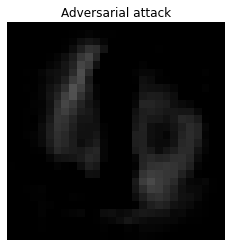

In [212]:
plt.imshow(np.transpose(make_image_grid(delta.detach()).numpy(), (1,2,0)))
plt.axis("off")
plt.title("Adversarial attack")

C:\Users\manug\AppData\Local\Temp\ipykernel_35928\3685681301.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e = torch.tensor(torch.randn(sd.size()))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Reconstructions')

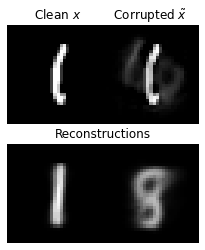

In [213]:
x_x_hat = torch.concat([images[0], images[0] + delta.detach()]).unsqueeze(1)
rec, _, _ = model(x_x_hat)

fig, axes = plt.subplots(2,1)

axes[0].imshow(np.transpose(make_image_grid(x_x_hat.detach()).numpy(), (1,2,0)))
axes[1].imshow(np.transpose(make_image_grid(rec.detach()).numpy(), (1,2,0)))

axes[0].axis("off")
axes[1].axis("off")

axes[0].set_title(r"    Clean $x$         Corrupted $\tilde{x}$")
axes[1].set_title("Reconstructions")


In [ ]:
# Now for the decoder

In [247]:
model = VAE((28,28), latent_dim=2,hidden_dim=256, return_zs=True)

In [248]:
def fisher_information_decoder(var=0.01):
    return torch.diag_embed(torch.ones(28*28)/var)

## Thats supper expensive
def jacobian_regularizer_decoder(zs):
    Js = batch_jacobian(lambda x: model.decoder(x).reshape(-1, 784), zs)
    return Js@torch.transpose(Js, dim0=-2, dim1=-1)

def better_jacobian_regularizer_decoder(zs, num_samples=10):
    samples_unit_sphere = torch.randn(zs.shape[0], 2)
    samples_unit_sphere /= torch.linalg.norm(samples_unit_sphere, axis=1).unsqueeze(-1)
    samples_unit_sphere *= zs.shape[-1]**0.5
    trace_est = 0
    for ii in range(num_samples):
        Jv = torch.autograd.functional.jvp(lambda x: model.decoder(x).reshape(-1, 784), zs, samples_unit_sphere, create_graph=True)[-1]
        trace_est += zs.shape[-1]*torch.linalg.norm(Jv, axis=1)**2/(num_samples)
    return 0.5*trace_est
 

def full_regularizer_decoder(zs, pert_var=0.1, var=0.01):
    return 1/var*0.5*pert_var*better_jacobian_regularizer_decoder(zs).mean()

In [249]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 4
elbo_list = []
for epoch in range(epochs):
    for images,_ in trainloader:
        x_in = images
        optimizer.zero_grad()
        x_out_mean, z_mu, z_logvar, zs = model(x_in)
        loss = elbo(x_in, z_mu, z_logvar, x_out_mean) + full_regularizer_decoder(zs)*10
        loss.backward() 
        optimizer.step()
        elbo_list.append(loss.detach().numpy())

C:\Users\manug\AppData\Local\Temp\ipykernel_35928\3685681301.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e = torch.tensor(torch.randn(sd.size()))


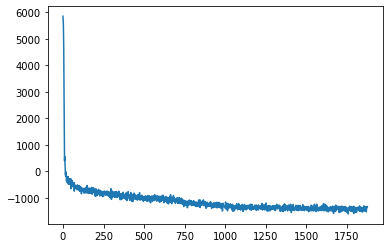

In [250]:
plt.plot(elbo_list)

C:\Users\manug\AppData\Local\Temp\ipykernel_35928\2144165698.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in = torch.tensor(images)
C:\Users\manug\AppData\Local\Temp\ipykernel_35928\3685681301.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e = torch.tensor(torch.randn(sd.size()))


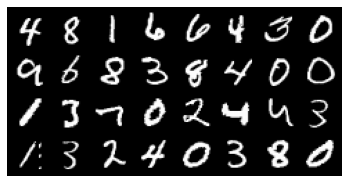

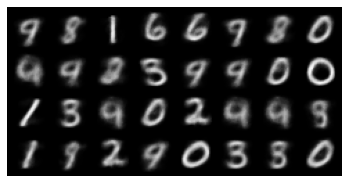

In [251]:
visualize_mnist_vae(model,trainloader)

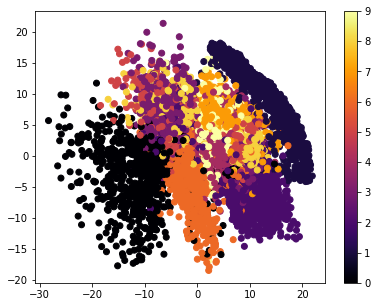

In [252]:
visualize_encoder(model,testloader)

Text(0.5, 1.0, 'Attacked point $x$                      Target $t$')

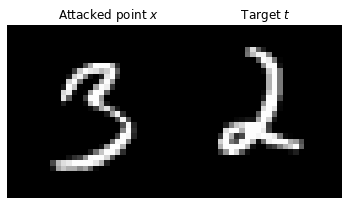

In [259]:
images,_ = iter(testloader).next()
images = images[0:2]
plt.imshow(np.transpose(make_image_grid(images).numpy(), (1,2,0)))
plt.axis("off")
plt.title(r"Attacked point $x$                      Target $t$")

In [260]:
means, logvars = model.encoder(images)
q_x = torch.distributions.MultivariateNormal(means[0], torch.eye(2)*logvars[0].exp())
q_t = torch.distributions.MultivariateNormal(means[1], torch.eye(2)*logvars[1].exp())
def distorted_latents(delta):
    means, logvars = model.encoder(images[0] + delta)
    return torch.distributions.MultivariateNormal(means, torch.eye(2)*logvars.exp())

In [261]:
delta = torch.randn(images[0].shape, requires_grad=True)

def adversarial_loss(delta, C=10):
    q_dist = distorted_latents(delta)
    loss =  torch.distributions.kl_divergence(q_dist, q_t) + C*torch.linalg.norm(delta)
    return loss

In [265]:
optimizer = torch.optim.Adam([delta], lr=5e-3)
for epoch in range(2000):
    optimizer.zero_grad()
    loss = adversarial_loss(delta, C=100)
    loss.backward(retain_graph=True) 
    if (epoch % 200) == 0:
        print(loss)
    optimizer.step()

tensor([892.5695], grad_fn=<AddBackward0>)
tensor([337.3733], grad_fn=<AddBackward0>)
tensor([308.8771], grad_fn=<AddBackward0>)
tensor([308.1167], grad_fn=<AddBackward0>)
tensor([308.1233], grad_fn=<AddBackward0>)
tensor([308.2052], grad_fn=<AddBackward0>)
tensor([309.0517], grad_fn=<AddBackward0>)
tensor([308.5813], grad_fn=<AddBackward0>)
tensor([308.5390], grad_fn=<AddBackward0>)
tensor([308.4721], grad_fn=<AddBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Adversarial attack')

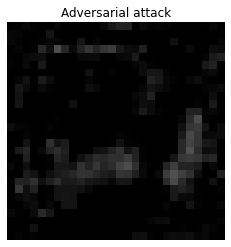

In [266]:
plt.imshow(np.transpose(make_image_grid(delta.detach()).numpy(), (1,2,0)))
plt.axis("off")
plt.title("Adversarial attack")

C:\Users\manug\AppData\Local\Temp\ipykernel_35928\3685681301.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e = torch.tensor(torch.randn(sd.size()))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Reconstructions')

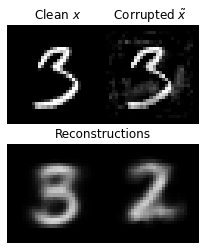

In [267]:
x_x_hat = torch.concat([images[0], images[0] + delta.detach()]).unsqueeze(1)
rec, _, _, _ = model(x_x_hat)

fig, axes = plt.subplots(2,1)

axes[0].imshow(np.transpose(make_image_grid(x_x_hat.detach()).numpy(), (1,2,0)))
axes[1].imshow(np.transpose(make_image_grid(rec.detach()).numpy(), (1,2,0)))

axes[0].axis("off")
axes[1].axis("off")

axes[0].set_title(r"    Clean $x$         Corrupted $\tilde{x}$")
axes[1].set_title("Reconstructions")


In [270]:
model = VAE((28,28), latent_dim=2,hidden_dim=256, return_zs=True)

In [294]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 4
elbo_list = []
for epoch in range(epochs):
    for images,_ in trainloader:
        x_in = images
        optimizer.zero_grad()
        x_out_mean, z_mu, z_logvar, zs = model(x_in)
        loss = elbo(x_in, z_mu, z_logvar, x_out_mean) + full_regularizer_decoder(zs)*5 + 5*full_regularizer(x_in, z_mu, z_logvar)
        loss.backward() 
        optimizer.step()
        elbo_list.append(loss.detach().numpy())

C:\Users\manug\AppData\Local\Temp\ipykernel_35928\3685681301.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e = torch.tensor(torch.randn(sd.size()))


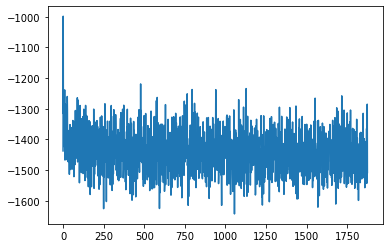

In [295]:
plt.plot(elbo_list)

C:\Users\manug\AppData\Local\Temp\ipykernel_35928\2144165698.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in = torch.tensor(images)
C:\Users\manug\AppData\Local\Temp\ipykernel_35928\3685681301.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e = torch.tensor(torch.randn(sd.size()))


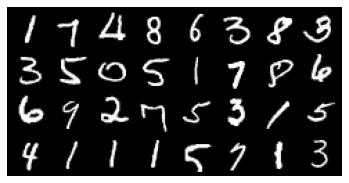

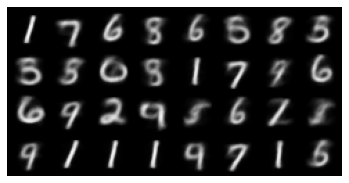

In [296]:
visualize_mnist_vae(model,trainloader)

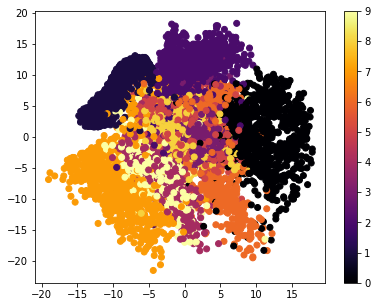

In [297]:
visualize_encoder(model,testloader)

Text(0.5, 1.0, 'Attacked point $x$                      Target $t$')

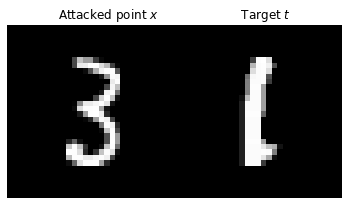

In [360]:
images,_ = iter(testloader).next()
images = images[0:2]
plt.imshow(np.transpose(make_image_grid(images).numpy(), (1,2,0)))
plt.axis("off")
plt.title(r"Attacked point $x$                      Target $t$")

In [361]:
means, logvars = model.encoder(images)
q_x = torch.distributions.MultivariateNormal(means[0], torch.eye(2)*logvars[0].exp())
q_t = torch.distributions.MultivariateNormal(means[1], torch.eye(2)*logvars[1].exp())
def distorted_latents(delta):
    means, logvars = model.encoder(images[0] + delta)
    return torch.distributions.MultivariateNormal(means, torch.eye(2)*logvars.exp())

In [362]:
delta = torch.randn(images[0].shape, requires_grad=True)

def adversarial_loss(delta, C=10):
    q_dist = distorted_latents(delta)
    loss =  torch.distributions.kl_divergence(q_dist, q_t) + C*torch.linalg.norm(delta)
    return loss

In [363]:
optimizer = torch.optim.Adam([delta], lr=5e-3)
for epoch in range(2000):
    optimizer.zero_grad()
    loss = adversarial_loss(delta, C=1)
    loss.backward(retain_graph=True) 
    if (epoch % 200) == 0:
        print(loss)
    optimizer.step()

tensor([104.0771], grad_fn=<AddBackward0>)
tensor([24.4015], grad_fn=<AddBackward0>)
tensor([18.6999], grad_fn=<AddBackward0>)
tensor([14.1350], grad_fn=<AddBackward0>)
tensor([10.7099], grad_fn=<AddBackward0>)
tensor([8.4542], grad_fn=<AddBackward0>)
tensor([7.1964], grad_fn=<AddBackward0>)
tensor([6.5776], grad_fn=<AddBackward0>)
tensor([6.3044], grad_fn=<AddBackward0>)
tensor([6.1873], grad_fn=<AddBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Adversarial attack')

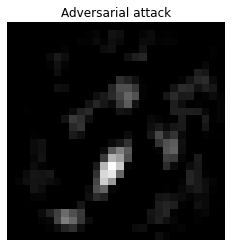

In [364]:
plt.imshow(np.transpose(make_image_grid(delta.detach()).numpy(), (1,2,0)))
plt.axis("off")
plt.title("Adversarial attack")

C:\Users\manug\AppData\Local\Temp\ipykernel_35928\3685681301.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e = torch.tensor(torch.randn(sd.size()))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Reconstructions')

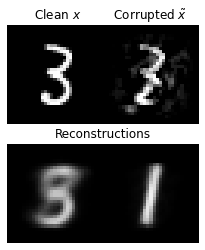

In [365]:
x_x_hat = torch.concat([images[0], images[0] + delta.detach()]).unsqueeze(1)
rec, _, _, _ = model(x_x_hat)

fig, axes = plt.subplots(2,1)

axes[0].imshow(np.transpose(make_image_grid(x_x_hat.detach()).numpy(), (1,2,0)))
axes[1].imshow(np.transpose(make_image_grid(rec.detach()).numpy(), (1,2,0)))

axes[0].axis("off")
axes[1].axis("off")

axes[0].set_title(r"    Clean $x$         Corrupted $\tilde{x}$")
axes[1].set_title("Reconstructions")